In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import os
import supervision as sv
from tqdm.notebook import tqdm
import cv2

In [2]:
HOME = os.getcwd()
print(HOME)

d:\Alexander\Go2Future\Autolabel_roboflow


In [4]:
# Crear el directorio "images" dentro del directorio actual si no existe
images_dir = os.path.join(HOME, "images")

if not os.path.exists(images_dir):
    os.mkdir(images_dir)

# Crear el directorio "videos" dentro del directorio actual si no existe
images_dir = os.path.join(HOME, "videos")

if not os.path.exists(images_dir):
    os.mkdir(images_dir)

In [3]:
VIDEO_DIR_PATH = f"{HOME}/videos"
IMAGE_DIR_PATH = f"{HOME}/images"
FRAME_STRIDE = 200

## Dividir los videos en imágenes

In [ ]:

video_paths = sv.list_files_with_extensions(
    directory=VIDEO_DIR_PATH,
    extensions=["mov", "mp4"])

TEST_VIDEO_PATHS, TRAIN_VIDEO_PATHS = video_paths[:1], video_paths

for video_path in tqdm(TRAIN_VIDEO_PATHS):
    video_name = video_path.stem
    image_name_pattern = video_name + "-{:05d}.jpg"
    with sv.ImageSink(target_dir_path=IMAGE_DIR_PATH, image_name_pattern=image_name_pattern) as sink:
        for image in sv.get_video_frames_generator(source_path=str(video_path), stride=FRAME_STRIDE):
            sink.save_image(image=image)

In [13]:
image_paths = sv.list_files_with_extensions(
    directory=IMAGE_DIR_PATH,
    extensions=["png", "jpg", "jpg"])

print('image count:', len(image_paths))

image count: 32


In [5]:
IMAGE_DIR_PATH = f"{HOME}/images"
SAMPLE_SIZE = 16
SAMPLE_GRID_SIZE = (4, 4)
SAMPLE_PLOT_SIZE = (16, 16)

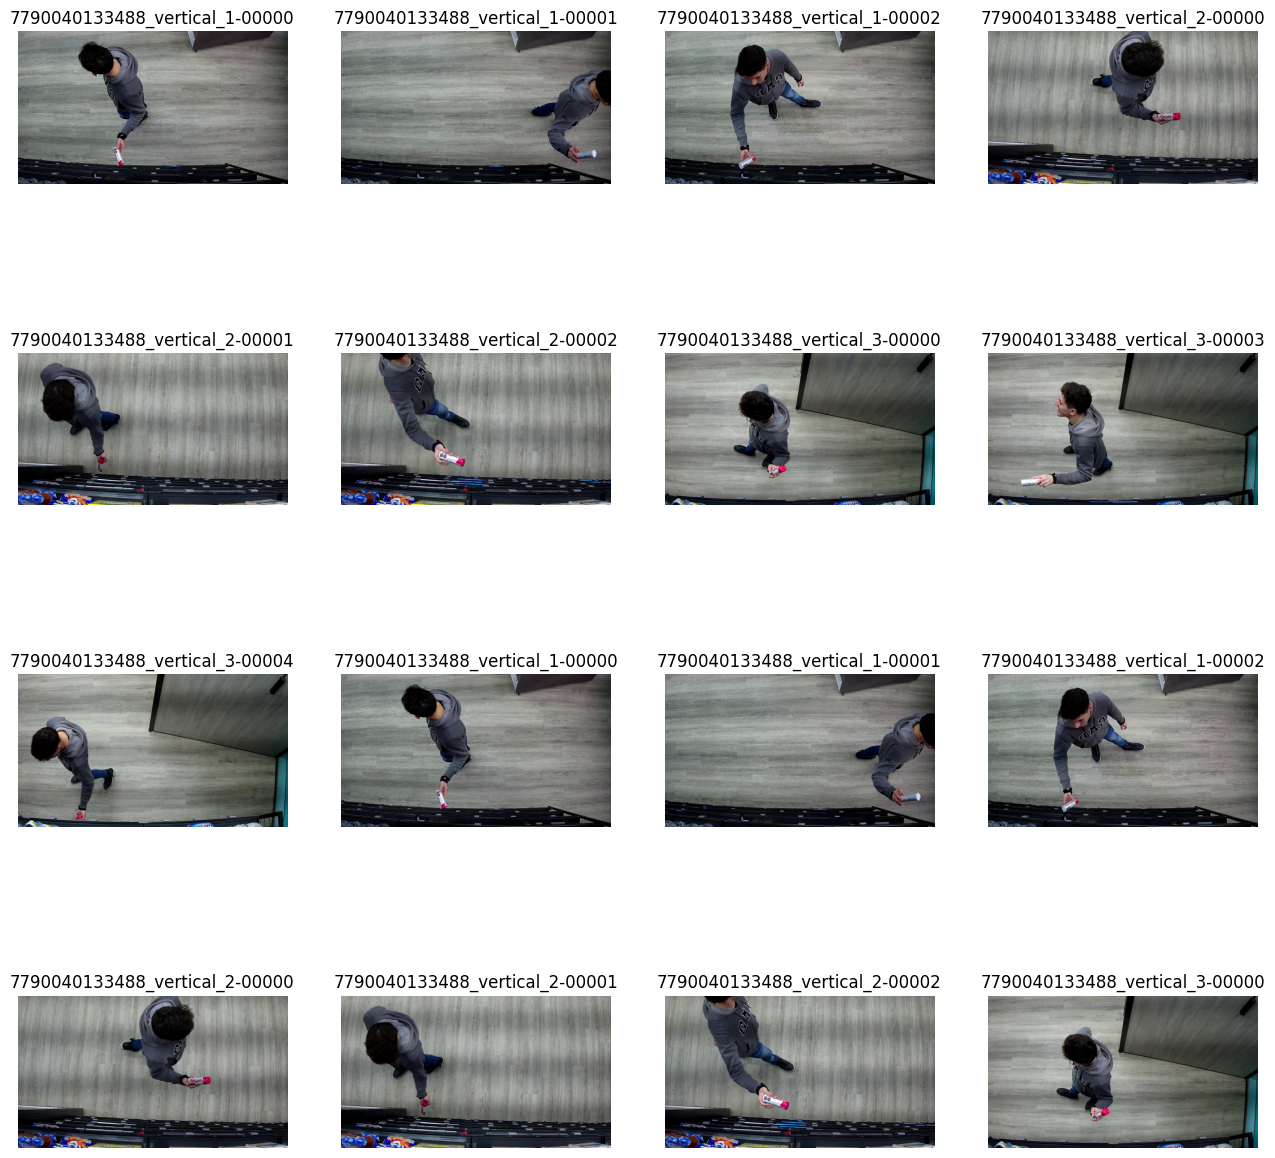

In [7]:
titles = [
    image_path.stem
    for image_path
    in image_paths[:SAMPLE_SIZE]]
images = [
    cv2.imread(str(image_path))
    for image_path
    in image_paths[:SAMPLE_SIZE]]

sv.plot_images_grid(images=images, titles=titles, grid_size=SAMPLE_GRID_SIZE, size=SAMPLE_PLOT_SIZE)

## Generar prompt para determinar que queremos que el modelo detecte

## Initiate base model and autolabel

In [7]:
DATASET_DIR_PATH = f"{HOME}/dataset"

### Grounded SAM

In [ ]:
from autodistill_grounded_sam import GroundedSAM

# load the model
base_model = GroundedSAM(ontology=ontology)


In [ ]:
# label all images in a folder called `context_images`
dataset = base_model.label(
    input_folder=IMAGE_DIR_PATH,
    extension=".jpg",
    output_folder=DATASET_DIR_PATH)

### Grounded OWL ViT

In [58]:
from autodistill_owl_vit import OWLViT

# load the model
base_vit = OWLViT(
    ontology=ontology,
    #box_threshold=0.35, 
    #text_threshold=0.25
    )

In [59]:
# label all images in a folder called `context_images`
dataset = base_vit.label(
    input_folder=IMAGE_DIR_PATH,
    extension=".jpg",
    output_folder=DATASET_DIR_PATH)

Labeling d:\Alexander\Go2Future\Autolabel_roboflow/images\7790040133488_vertical_3-00004.jpg: 100%|██████████| 9/9 [00:15<00:00,  1.72s/it]


Labeled dataset created - ready for distillation.


### Grounded DINO

In [8]:
from autodistill_grounding_dino import GroundingDINO
# load the model
base_model = GroundingDINO(
    ontology=ontology,
    box_threshold=0.35, 
    text_threshold=0.25)

trying to load grounding dino directly


d:\Alexander\Go2Future\Autolabel_roboflow\.venv\Lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


In [103]:
# label all images in a folder called `context_images`
dataset = base_model.label(
    input_folder=IMAGE_DIR_PATH,
    extension=".jpg",
    output_folder=DATASET_DIR_PATH)

Labeling d:\Alexander\Go2Future\Autolabel_roboflow/images\7790040133488_vertical_3-00004.jpg: 100%|██████████| 9/9 [04:05<00:00, 27.23s/it]


Labeled dataset created - ready for distillation.


In [4]:
ANNOTATIONS_DIRECTORY_PATH = f"{HOME}/dataset/7790040133488/train/labels"
IMAGES_DIRECTORY_PATH = f"{HOME}/dataset/7790040133488/train/images"
DATA_YAML_PATH = f"{HOME}/dataset/7790040133488/data.yaml"

In [5]:
dataset = sv.DetectionDataset.from_yolo(
    images_directory_path=IMAGES_DIRECTORY_PATH,
    annotations_directory_path=ANNOTATIONS_DIRECTORY_PATH,
    data_yaml_path=DATA_YAML_PATH)

len(dataset)

11

In [6]:
ANNOTATIONS_DIRECTORY_PATH2 = f"{HOME}/dataset/7790040133489/train/labels"
IMAGES_DIRECTORY_PATH2 = f"{HOME}/dataset/7790040133489/train/images"
DATA_YAML_PATH2 = f"{HOME}/dataset/7790040133489/data.yaml"

In [7]:
dataset2 = sv.DetectionDataset.from_yolo(
    images_directory_path=IMAGES_DIRECTORY_PATH2,
    annotations_directory_path=ANNOTATIONS_DIRECTORY_PATH2,
    data_yaml_path=DATA_YAML_PATH2)

len(dataset)

11

In [28]:
from src.util import merge_datasets
from src import config

# Paths to individual datasets
folders=os.listdir(config.DATASET_DIR_PATH)
# get all full folder path into the folder Dataset
dataset_paths=[os.path.join(config.DATASET_DIR_PATH, folder) for folder in folders]

output_path = os.path.join(config.DATASET_DIR_PATH, "Merge_Dataset")
merge_datasets(dataset_paths, output_path)


In [31]:
ANNOTATIONS_DIRECTORY_PATH2 = f"{HOME}/dataset/Merge_Dataset/train/labels"
IMAGES_DIRECTORY_PATH2 = f"{HOME}/dataset/Merge_Dataset/train/images"
DATA_YAML_PATH2 = f"{HOME}/dataset/Merge_Dataset/data.yaml"

dataset = sv.DetectionDataset.from_yolo(
    images_directory_path=IMAGES_DIRECTORY_PATH2,
    annotations_directory_path=ANNOTATIONS_DIRECTORY_PATH2,
    data_yaml_path=DATA_YAML_PATH2)

len(dataset)

22

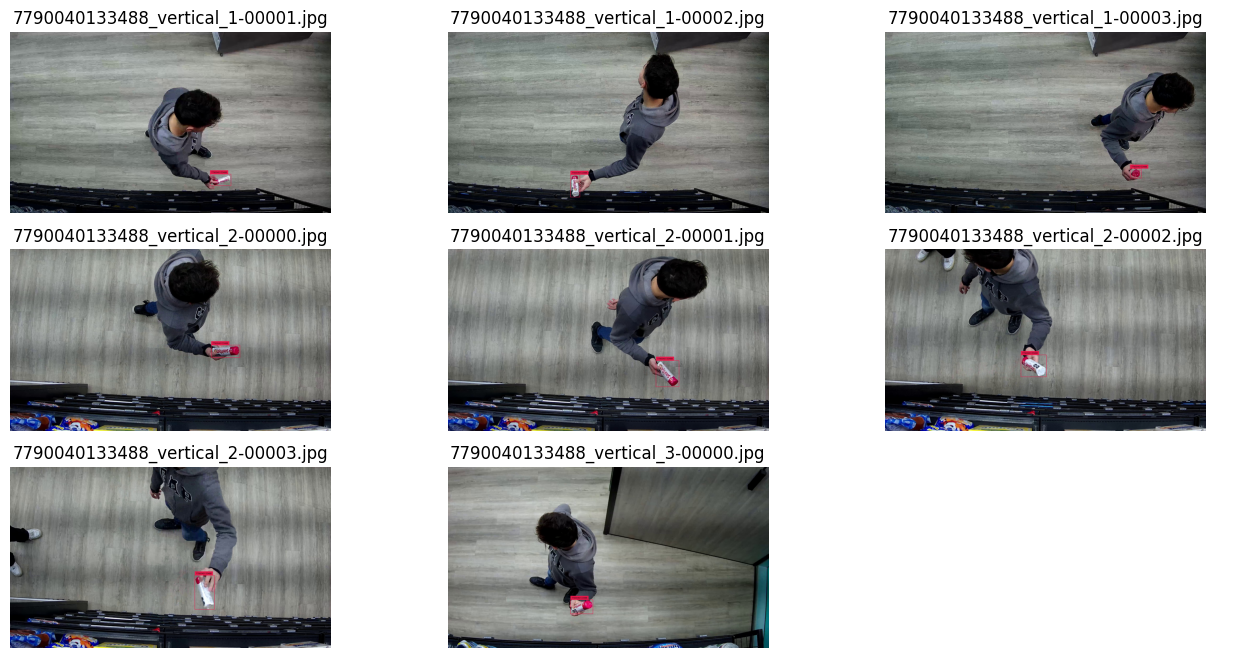

In [32]:
SAMPLE_SIZE = 8
SAMPLE_GRID_SIZE = (3, 3)
SAMPLE_PLOT_SIZE = (16, 8)

image_names = list(dataset.images.keys())[:SAMPLE_SIZE]

mask_annotator = sv.MaskAnnotator()
box_annotator = sv.BoxAnnotator()

images = []
for image_name in image_names:
    image = dataset.images[image_name]
    annotations = dataset.annotations[image_name]
    labels = [
        dataset.classes[class_id]
        for class_id
        in annotations.class_id]
    annotates_image = mask_annotator.annotate(
        scene=image.copy(),
        detections=annotations)
    annotates_image = box_annotator.annotate(
        scene=annotates_image,
        detections=annotations,
        labels=labels)
    images.append(annotates_image)

sv.plot_images_grid(
    images=images,
    titles=image_names,
    grid_size=SAMPLE_GRID_SIZE,
    size=SAMPLE_PLOT_SIZE)

In [ ]:
imag_alone_path=f"{HOME}/images/7790040133488_vertical_1-00004.jpg"

detections = base_model.predict(imag_alone_path)
image=cv2.imread(str(imag_alone_path))

mask_annotator = sv.MaskAnnotator()
box_annotator = sv.BoxAnnotator()

annotates_image = mask_annotator.annotate(
        scene=image.copy(),
        detections=detections)

annotates_image = box_annotator.annotate(
        scene=annotates_image,
        detections=detections,
        labels=["product"]
        )
        
%matplotlib inline  
sv.plot_image(annotates_image, (16, 16))

In [22]:
base_model.ontology=CaptionOntology({"hand":"hand"})
